In [1]:
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import pywt
import numpy as np
import torchvision.models as models


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
#Image load taks
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
# Load the original CSV file
df = pd.read_csv('train/train_labels.csv')

# Select 50 random entries
df_sampled = df.sample(n=50)       #, random_state=42)

# Save the new CSV file
df_sampled.to_csv('train/sample_labels.csv', index=False)

print("New file with 50 entries has been created.")


New file with 50 entries has been created.


In [5]:

train_dataset = ImageDataset(csv_file='train/sample_labels.csv', root_dir='train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)


In [6]:
# Load the original CSV file
df = pd.read_csv('test/test_labels.csv')

# Select 50 random entries
df_sampled = df.sample(n=50)      #, random_state=42)

# Save the new CSV file
df_sampled.to_csv('test/sample_labels.csv', index=False)

print("New file with 50 entries has been created.")

New file with 50 entries has been created.


In [7]:

test_dataset = ImageDataset(csv_file='test/sample_labels.csv', root_dir='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=4)



In [8]:


# Define the DWT layer
class DWT(nn.Module):
    def __init__(self):
        super(DWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        x = torch.mean(x, dim=1, keepdim=True)
        
        return dwt_init(x)

def dwt_init(x):
    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4
    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)


In [9]:
class Block(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, wavelet='haar'):
        super(Block, self).__init__()
        
        # Define the Conv2d layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # Define ReLU activation
        self.relu = nn.ReLU(inplace=True)
        self.dwt_layer = DWT()
    
    def forward(self, x):
        # Apply 3 Conv2d layers with ReLU activations
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        #Apply DWT layer
        x = self.dwt_layer(x)
        
        return x

In [10]:

class MWCNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, wavelet='haar'):
        super(MWCNN, self).__init__()
        #with Dwt
        # Define two Block instances
        self.block1 = Block(in_channels=in_channels, out_channels=out_channels, wavelet=wavelet)
        self.block2 = Block(in_channels=4, out_channels=128, wavelet=wavelet)
        self.block3 = Block(in_channels=4, out_channels=256, wavelet=wavelet)
        self.block4 = Block(in_channels=4, out_channels=512, wavelet=wavelet)
        self.block5 = Block(in_channels=4, out_channels=1024, wavelet=wavelet)
        
        self.fc1 = nn.Linear(4 * 7 * 7, 512)  # Adjust size according to input image size
        self.fc2 = nn.Linear(512, 4)  # Assuming 10 classes for classification
        
    def forward(self, x):
        # Pass input through the first Block
        x = self.block1(x)
    
        x = self.block2(x)

        x = self.block3(x)
    
        x = self.block4(x)
    
        x = self.block5(x)
    

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [11]:

class Teacher(nn.Module):
    def __init__(self, resnet18):
        super(Teacher, self).__init__()
        
        # Initialize the two models
        self.resnet18 = resnet18
               
    def forward(self, x):
        
        # Get predictions from ResNet18
        resnet_pred = self.resnet18(x)
        
        return resnet_pred

In [12]:

def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss)
        # Iterate through each named parameter (weights) in the model
        k = 0
        # for name, param in model.named_parameters():
        #     print(f"Layer: {name} | Weights: {param.data}")
        #     k = k + 1
        #     if k == 1:
        #         break
    return losses

In [13]:

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss)
        
    return losses


In [14]:
def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [15]:

# Initialize the ResNet18 model (pretrained on ImageNet)
resnet18_model = models.resnet18(pretrained=False)

# Modify the final layer of ResNet18 for the desired number of classes (assuming 10 classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 4)

/home/intern1/anaconda3/envs/envpytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/intern1/anaconda3/envs/envpytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
#torch.manual_seed(42)
# Set the device to the desired GPU (e.g., GPU 0)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
teacher = Teacher(resnet18_model).to(device)
student = MWCNN(in_channels=3, out_channels=64, wavelet='haar').to(device)

In [17]:

# nn_deep = DeepNN(num_classes=10).to(device)
teacher_losses = train(teacher, train_dataloader, epochs=100, learning_rate=0.05, device=device)
test_accuracy_teacher = test(teacher, test_dataloader, device)

Epoch 1/100, Loss: 11.873554158210755
Epoch 2/100, Loss: 1.92475368976593
Epoch 3/100, Loss: 2.2550023674964903
Epoch 4/100, Loss: 2.0494012117385862
Epoch 5/100, Loss: 1.1894927024841309
Epoch 6/100, Loss: 1.425169825553894
Epoch 7/100, Loss: 1.1738876819610595
Epoch 8/100, Loss: 1.233798575401306
Epoch 9/100, Loss: 1.4019312143325806
Epoch 10/100, Loss: 1.3262563228607178
Epoch 11/100, Loss: 1.252045464515686
Epoch 12/100, Loss: 1.0178536534309388
Epoch 13/100, Loss: 1.2767598628997803
Epoch 14/100, Loss: 1.0140418887138367
Epoch 15/100, Loss: 1.0624485969543458
Epoch 16/100, Loss: 1.1052547216415405
Epoch 17/100, Loss: 1.024882471561432
Epoch 18/100, Loss: 1.3088295340538025
Epoch 19/100, Loss: 1.0646619915962219
Epoch 20/100, Loss: 0.9458852052688599
Epoch 21/100, Loss: 0.9323419332504272
Epoch 22/100, Loss: 0.8730276823043823
Epoch 23/100, Loss: 0.9247563719749451
Epoch 24/100, Loss: 1.0022771120071412
Epoch 25/100, Loss: 0.9963290810585022
Epoch 26/100, Loss: 1.0635855317115783
E

In [18]:
test_accuracy_teacher = test(teacher, test_dataloader, device)

Test Accuracy: 32.00%


In [19]:

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
losses_student_KD = train_knowledge_distillation(teacher=teacher, student=student, train_loader=train_dataloader, epochs=100, learning_rate=0.05, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_student_ce_and_kd = test(student, test_dataloader, device)

Epoch 1/100, Loss: 22372.732557058334
Epoch 2/100, Loss: 2.5826849222183226
Epoch 3/100, Loss: 1.281933641433716
Epoch 4/100, Loss: 1.243755054473877
Epoch 5/100, Loss: 1.2418089866638184
Epoch 6/100, Loss: 1.2442756175994873
Epoch 7/100, Loss: 1.2543241500854492
Epoch 8/100, Loss: 1.2411187887191772
Epoch 9/100, Loss: 1.2437463521957397
Epoch 10/100, Loss: 1.2415759086608886
Epoch 11/100, Loss: 1.240998888015747
Epoch 12/100, Loss: 1.2433966398239136
Epoch 13/100, Loss: 1.2439113140106202
Epoch 14/100, Loss: 1.2436015129089355
Epoch 15/100, Loss: 1.2391072750091552
Epoch 16/100, Loss: 1.2399058580398559
Epoch 17/100, Loss: 1.2405001640319824
Epoch 18/100, Loss: 1.2413580656051635
Epoch 19/100, Loss: 1.241794180870056
Epoch 20/100, Loss: 1.2400852203369142
Epoch 21/100, Loss: 1.2435759067535401
Epoch 22/100, Loss: 1.2444658041000367
Epoch 23/100, Loss: 1.2436664342880248
Epoch 24/100, Loss: 1.243255352973938
Epoch 25/100, Loss: 1.2412028551101684
Epoch 26/100, Loss: 1.2416067600250245


In [24]:

# Creating a dictionary
data = {
    'Variable': ['test_accuracy_teacher', 'test_accuracy_student_ce_and_kd'],
    'Value': [test_accuracy_teacher, test_accuracy_student_ce_and_kd]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Saving to CSV
filename = 'accuracies.csv'
df.to_csv(filename, index=False)

print(f'Variables saved to {filename}')

Variables saved to accuracies.csv


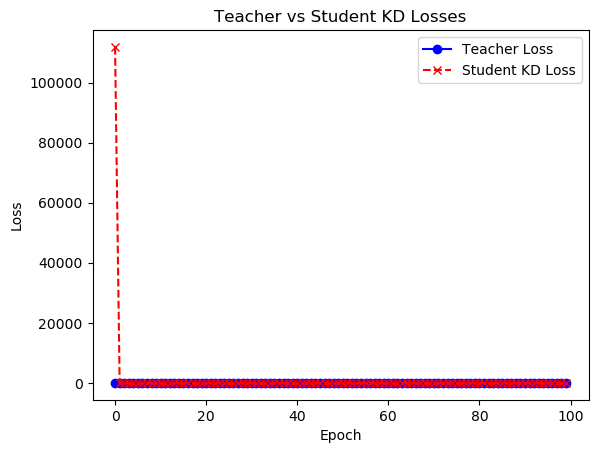

In [20]:
import matplotlib.pyplot as plt

# # Example lists of losses (replace with your actual lists)
# teacher_losses = [0.9, 0.85, 0.8, 0.78, 0.75, 0.7, 0.65, 0.63, 0.6, 0.58]
# losses_student_KD = [0.88, 0.82, 0.78, 0.74, 0.71, 0.68, 0.64, 0.61, 0.59, 0.56]

# Step 1: Plot teacher losses
plt.plot(teacher_losses, marker='o', linestyle='-', color='b', label='Teacher Loss')

# Step 2: Plot student KD losses
plt.plot(losses_student_KD, marker='x', linestyle='--', color='r', label='Student KD Loss')

# Step 3: Add titles and labels
plt.title('Teacher vs Student KD Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Step 4: Add a legend
plt.legend()

# Step 5: Save the plot to the current folder
plt.savefig('teacher_vs_student_KD_loss_plot.png')

# Step 6: Show the plot (optional)
plt.show()


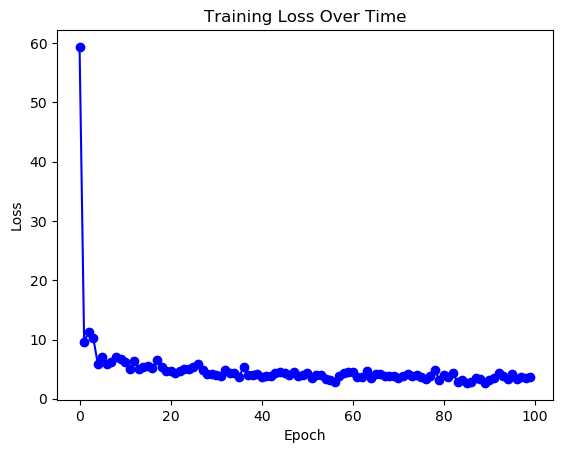

In [21]:
import matplotlib.pyplot as plt


# Step 1: Plot the losses
plt.plot(teacher_losses, marker='o', linestyle='-', color='b')

# Step 2: Add titles and labels
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Step 3: Save the plot to the current folder
plt.savefig('loss_plot.png')

# Step 4: Show the plot (optional)
plt.show()


In [22]:
k = 0
for images, target in train_dataloader:
    mwcnn = MWCNN()
    output = mwcnn(images)
    print(output.shape)
    k = k + 1
    if k == 1:
        break
    

torch.Size([10, 4])


In [23]:
import torch

# Example tensor of shape [10, 3, 224, 224]
tensor_batch = torch.rand(10, 3, 224, 224)  # Replace with your actual tensor
print(tensor_batch.shape)


# Step 1: Take the mean across the channel dimension (dim=1)
tensor_avg = torch.mean(tensor_batch, dim=1, keepdim=True)  # Resulting shape will be [10, 1, 224, 224]

# The tensor_avg now has the shape [10, 1, 224, 224]
print(tensor_avg.shape)


torch.Size([10, 3, 224, 224])
torch.Size([10, 1, 224, 224])
